In [1]:
# HIDDEN
from datascience import *
from prob140 import *
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import math
from scipy import stats
from scipy import misc

## Transitions ##

Let $X_0, X_1, X_2, \ldots $ be a Markov chain with state space $S$. By the Markov property, the probability of a *trajectory* or *path* of finite length is

\begin{align*}
& P(X_0 = i_0, X_1 = i_1, X_2 = i_2, \ldots, X_n = i_n) \\
& = ~ 
P(X_0 = i_0)P(X_1 = i_1 \mid X_0 = i_0)P(X_2 = i_2 \mid X_1 = i_1) \cdots
P(X_n = i_n \mid X_{n-1} = i_{n-1})
\end{align*}

The conditional probabilities in the product are called *transition probabilities*. For states $i$ and $j$, the conditional probability $P(X_{n+1} = j \mid X_n = i)$ is called a *one-step transition probability at time $n$*. 

For many chains such as the random walk, these one-step transition probabilities depend only on the states $i$ and $j$, not on the time $n$. For example, for the random walk,

\begin{equation}
P(X_{n+1} = j \mid X_n = i) = 
 \begin{cases} 
      \frac{1}{2} & \text{if } j = i-1 \text{ or } j = i+1 \\
      0 & \text{ otherwise}
   \end{cases}
\end{equation}

for every $n$. 

### Stationary Transition Probabilities ###
When one-step transition probabilites don't depend on $n$, they are called *stationary* or *time-homogenous*. All the Markov chains that we will study in this course have time-homogenous transition probabilities.

For such a chain, define the *one-step transition probability*

$$
P(i, j) ~ = ~ P(X_{n+1} = j \mid X_n = i) ~ = ~ P(X_1 = j \mid X_0 = i)
$$
Then
$$
P(X_0 = i_0, X_1 = i_1, X_2 = i_2, \ldots, X_n = i_n)
~ = ~ P(X_0 = i_0)P(i_0, i_1)P(i_1, i_2) \cdots P(i_{n-1}, i_n)
$$

The one-step transition probabilities can be represented as elements of a matrix. This isn't just for compactness of notation – it leads to a powerful theory.

### One-Step Transition Matrix ###
The *one-step transition matrix* of the chain is the matrix $\mathbb{P}$ whose $(i, j)$th element is $P(i, j) = P(X_1 = j \mid X_0 = i)$.

Often, $\mathbb{P}$ is just called *the transition matrix* for short. Note two important properties:

- $\mathbb{P}$ is a square matrix: its rows as well as its columns are indexed by the state space.
- Each row of $\mathbb{P}$ is a distribution: for each state $i$, and each $n$, Row $i$ of the transition matrix is the conditional distribution of $X_{n+1}$ given that $X_n = i$. Because each of its rows adds up to 1, $\mathbb{P}$ is called a *stochastic matrix*.

Let's see what the transition matrix looks like in an example. 

### Sticky Reflecting Random Walk ###
Often, the transition behavior of a Markov chain is easier to describe in a *transition diagram* instead of a matrix. Here is such a diagram for a chain on the states 1, 2, 3, 4, and 5. The diagram shows the one-step transition probabilities.
- If the chain is at any state, it stays there with chance 0.5.
- If the chain is at states 2 through 4, it moves to each of its two adjacent state with chance 0.25.
- If the chain is at states 1 or 5, it moves to its adjacent state with chance 0.5

![Reflecting Lazy Walk](trans_refl.png)

We say that there is *reflection* at states 1 and 5. The walk is *sticky* because of the positive chance of staying in place.

Transition diagrams are great for understanding the rules by which a chain moves. For calculations, however, the transition matrix is more helpful.

To start constructing the matrix, we set the array `s` to be the set of states and the transition function `refl_walk_probs` to take arguments $i$ and $j$ and return $P(i, j)$.

In [2]:
s = np.arange(1, 6)

def refl_walk_probs(i, j):
    # staying in the same state
    if i-j == 0:
        return 0.5
    
    # moving left or right
    elif 2 <= i <= 4:
        if abs(i-j) == 1:
            return 0.25
        else:
            return 0
        
    # moving right from 1
    elif i == 1:
        if j == 2:
            return 0.5
        else:
            return 0
    
    # moving left from 5
    elif i == 5:
        if j == 4:
            return 0.5
        else:
            return 0

You can use the `prob140` library to construct `MarkovChain` objects. The `from_transition_function` method takes two arguments:
- an array of the states
- a transition function

and displays the one-step transition matrix of a `MarkovChain` object.

In [3]:
reflecting_walk = MarkovChain.from_transition_function(s, refl_walk_probs)
reflecting_walk

,1,2,3,4,5
1,0.50,0.50,0.00,0.00,0.00
2,0.25,0.50,0.25,0.00,0.00
3,0.00,0.25,0.50,0.25,0.00
4,0.00,0.00,0.25,0.50,0.25
5,0.00,0.00,0.00,0.50,0.50


Compare the transition matrix $\mathbb{P}$ with the transition diagram, and confirm that they contain the same information about transition probabilities.

To find the chance that the chain moves to $j$ given that it is at $i$, go to Row $i$ and pick out the probability in Column $j$.

If you know the starting state, you can use $\mathbb{P}$ to find the probability of any finite path. For example, given that the walk starts at 1, the probability that it then has the path [2, 2, 3, 4, 3] is

$$
P(1, 2)P(2, 2)P(2, 3)P(3, 4)P(4, 3) \approx 0.4\%
$$

In [4]:
0.5 * 0.5 * 0.25 * 0.25 * 0.25

0.00390625

The `MarkovChain` method `prob_of_path` saves you the trouble of doing the multiplication. It takes as its arguments the starting state and the rest of the path (in a list or array), and returns the probability of the path.

In [5]:
reflecting_walk.prob_of_path(1, [2, 2, 3, 4, 3])

0.00390625

In [6]:
reflecting_walk.prob_of_path(1, [2, 2, 3, 4, 3, 5])

0.0

You can simulate paths of the chain using the `simulate_path` method. It takes two arguments: the starting state and the number of steps of the path. By default it returns an array consisting of the sequence of states in the path. The optional argument `plot_path=True` plots the simulated path. Run the cells below a few times and see how the output changes.

In [7]:
reflecting_walk.simulate_path(1, 7)

array([1, 2, 2, 2, 3, 4, 3, 3])

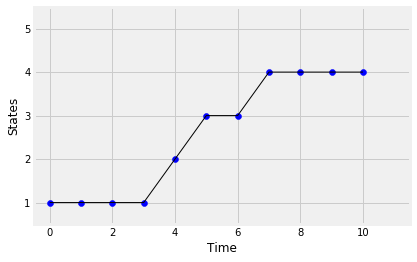

In [8]:
reflecting_walk.simulate_path(1, 10, plot_path=True)

### $n$-Step Transition Matrix ###
For states $i$ and $j$, the chance of getting from $i$ to $j$ in $n$ steps is called the $n$-step transition probability from $i$ to $j$. Formally, the $n$-step transition probability is

$$
P_n(i, j) ~ = ~ P(X_n = j \mid X_0 = i)
$$

In this notation, the one-step transition probability $P(i, j)$ can also be written as $P_1(i, j)$.

The $n$-step transition probability $P_n(i, j)$ can be represented as the $(i, j)$th element of a matrix called the $n$-step transition matrix. For each state $i$, Row $i$ of the $n$-step transition matrix contains the distribution of $X_n$ given that the chain starts at $i$.

The `MarkovChain` method `transition_matrix` takes $n$ as its argument and displays the $n$-step transition matrix. Here is the 2-step transition matrix of the reflecting walk defined earlier in this section.

In [9]:
reflecting_walk.transition_matrix(2)

,1,2,3,4,5
1,0.3750,0.5000,0.125,0.0000,0.0000
2,0.2500,0.4375,0.250,0.0625,0.0000
3,0.0625,0.2500,0.375,0.2500,0.0625
4,0.0000,0.0625,0.250,0.4375,0.2500
5,0.0000,0.0000,0.125,0.5000,0.3750


You can calculate the individual entries easily by hand. For example, the $(1, 1)$ entry is the chance of going from state 1 to state 1 in 2 steps. There are two paths that make this happen:
- [1, 1, 1]
- [1, 2, 1]

Given that 1 is the starting state, the total chance of the two paths is $(0.5 \times 0.5) + (0.5 \times 0.25) = 0.375$.

Because of the Markov property, the one-step transition probabilities are all you need to find the 2-step transition probabilities. 

In general, we can find $P_2(i, j)$ by conditioning on where the chain was at time 1.

\begin{align*}
P_2(i, j) ~ &= ~ P(X_2 = j \mid X_0 = i) \\
&= ~ \sum_k P(X_1 = k, X_2 = j \mid X_0 = i) \\
&= ~ \sum_k P(X_1 = k \mid X_0 = i)P(X_2 = j \mid X_1 = k) \\
&= ~ \sum_k P(i, k)P(k, j)
\end{align*}

That's the $(i, j)$th element of the matrix product $\mathbb{P} \times \mathbb{P} = \mathbb{P}^2$. Thus the 2-step transition matrix of the chain is $\mathbb{P}^2$.

By induction, you can show that the $n$-step transition matrix of the chain is $\mathbb{P}^n$.

Here is a display of the 5-step transition matrix of the reflecting walk.

In [10]:
reflecting_walk.transition_matrix(5)

,1,2,3,4,5
1,0.246094,0.410156,0.234375,0.089844,0.019531
2,0.205078,0.363281,0.250000,0.136719,0.044922
3,0.117188,0.250000,0.265625,0.250000,0.117188
4,0.044922,0.136719,0.250000,0.363281,0.205078
5,0.019531,0.089844,0.234375,0.410156,0.246094


This is a display, but to work with the matrix we have to represent it in a form that Python recognizes as a matrix. The method `get_transition_matrix` does this for us. It take the number of steps $n$ as its argument and returns the $n$-step transition matrix as a NumPy matrix.

For the reflecting walk, we will start by extracting $\mathbb{P}$ as the matrix `refl_walk_P`.

In [11]:
refl_walk_P = reflecting_walk.get_transition_matrix(1)
refl_walk_P

array([[ 0.5 ,  0.5 ,  0.  ,  0.  ,  0.  ],
       [ 0.25,  0.5 ,  0.25,  0.  ,  0.  ],
       [ 0.  ,  0.25,  0.5 ,  0.25,  0.  ],
       [ 0.  ,  0.  ,  0.25,  0.5 ,  0.25],
       [ 0.  ,  0.  ,  0.  ,  0.5 ,  0.5 ]])

Let's check that the 5-step transition matrix displayed earlier is the same as $\mathbb{P}^5$. You can use `np.linalg.matrix_power` to raise a matrix to a non-negative integer power. The first argument is the matrix, the second is the power.

In [12]:
np.linalg.matrix_power(refl_walk_P, 5)

array([[ 0.24609375,  0.41015625,  0.234375  ,  0.08984375,  0.01953125],
       [ 0.20507812,  0.36328125,  0.25      ,  0.13671875,  0.04492188],
       [ 0.1171875 ,  0.25      ,  0.265625  ,  0.25      ,  0.1171875 ],
       [ 0.04492188,  0.13671875,  0.25      ,  0.36328125,  0.20507812],
       [ 0.01953125,  0.08984375,  0.234375  ,  0.41015625,  0.24609375]])

That is indeed the same as the matrix displayed by `transition_matrix` though harder to read.

When we want to use $\mathbb{P}$ in computations, we will use this matrix representation. For displays, `transition_matrix` is better.

### The Long Run ###

To understand the long run behavior of the chain, let $n$ be large and let's examine the distribution of $X_n$ for each value of the starting state. That's contained in the $n$-step transition matrix $\mathbb{P}^n$. 

Here is the display of $\mathbb{P}^n$ for the reflecting walk, for $n = 25, 50$, and $100$.

In [13]:
reflecting_walk.transition_matrix(25)

,1,2,3,4,5
1,0.129772,0.256749,0.25,0.243251,0.120228
2,0.128374,0.254772,0.25,0.245228,0.121626
3,0.125000,0.250000,0.25,0.250000,0.125000
4,0.121626,0.245228,0.25,0.254772,0.128374
5,0.120228,0.243251,0.25,0.256749,0.129772


In [14]:
reflecting_walk.transition_matrix(50)

,1,2,3,4,5
1,0.125091,0.250129,0.25,0.249871,0.124909
2,0.125064,0.250091,0.25,0.249909,0.124936
3,0.125000,0.250000,0.25,0.250000,0.125000
4,0.124936,0.249909,0.25,0.250091,0.125064
5,0.124909,0.249871,0.25,0.250129,0.125091


In [15]:
reflecting_walk.transition_matrix(100)

,1,2,3,4,5
1,0.125,0.25,0.25,0.25,0.125
2,0.125,0.25,0.25,0.25,0.125
3,0.125,0.25,0.25,0.25,0.125
4,0.125,0.25,0.25,0.25,0.125
5,0.125,0.25,0.25,0.25,0.125


The rows of $\mathbb{P}^{100}$ are all the same! That means that for the reflecting walk, the distribution at time 100 doesn't depend on the starting state. *The chain has forgotten where it started.*

You can increase $n$ and see that the $n$-step transition matrix stays the same. By time 100, this chain has *reached stationarity*.

Stationarity is a remarkable property of many Markov chains, and is the main topic of this chapter.